In [1]:
import numpy as np
import tensorflow as tf
import convenience_utils as utils
import tiff_utils

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
class VariationalAutoEncoder(object):

    def __init__(self, encoder_arch, decoder_arch,
                 learning_rate=1e-4, nonlinearity=tf.nn.relu):

        self.encoder = None
        self.decoder = None

        self.learning_rate = learning_rate
        self.nonlinearity = nonlinearity

        self._construct_encoder(encoder_arch)
        self._construct_decoder(decoder_arch)

        self.loss_function = self._get_loss_function(self.input, self.output)
        self.optimizer = self._get_optimizer(learning_rate, self.loss_function)

        self._create_internal_session()
        self._create_internal_saver()

    
    def train(self, batch_size, data_stream, epochs, to_save_path=None, verbose=False, every=1000):
        '''
        The train method allows you to train your autoencoder on different datasets fairly hands-free
        It does demand as input a data_stream object, which implements a method called next_batch()
        that returns a tensor of dimension [input_size, batch_size], or [x, y, pixel_depth, batch_size] for the
        convolutional case.
        '''

        self.internal_session.run(tf.global_variables_initializer())
        test_data = data_stream.test_batch(1)

        for i in range(epochs):
            image_batch = data_stream.next_batch(batch_size=batch_size)
#             image_batch = image_batch - np.mean(image_batch, 0)
#             image_batch = image_batch / np.var(image_batch, 0)
#             image_batch = image_batch / np.max(image_batch) * 10

            _, cost, result = self.internal_session.run(
                [self.optimizer, self.loss_function, self.output],
                feed_dict={self.input: image_batch}
            )

            if verbose and (i % every == 0):
                print 'Round: %d' % (i + 1), 'cost = %f' % cost

            if to_save_path is not None and (i % every == 0):
                self._save_model(to_save_path)


    def predict(self, new_data):
        return self.internal_session.run(self.output,
                feed_dict={self.input: new_data})
    
    
    def predict_from_embedding(self, new_data_mean, new_data_stddev):
        return self.internal_session.run(self.output,
                                        feed_dict={self.encoder: (new_data_mean, new_data_stddev)})
    

    def get_embedding(self, input_batch):
        return self.internal_session.run(self.encoder, feed_dict={self.input: input_batch})


    def _save_model(self, to_save_path):
        self.saved_path = self.saver.save(self.internal_session, to_save_path)
        print 'Model saved at location: ', self.saved_path
        
    
    def _restore_model(self, saved_path):
        self.saver.restore(self.internal_session, saved_path)


    def _get_weights_and_biases(self, widths):
        weights = []
        biases = []

        initializer = tf.contrib.layers.xavier_initializer()
        for layer in range(len(widths)-1):
            weights.append(tf.Variable(initializer((widths[layer], widths[layer+1]))))
            biases.append(tf.Variable(tf.constant(0.1, shape=(widths[layer+1], ))))

        return weights, biases


    def _get_network(self, weights, biases, inp):

        h = inp
        for layer in range(len(weights)-1):
            h = self.nonlinearity(tf.add(tf.matmul(h, weights[layer]), biases[layer]))

        return tf.add(tf.matmul(h, weights[-1]), biases[-1])


    def _construct_encoder(self, encoder_architecture):
        '''
        Construct an encoder architecture from the list of sizes given in
        the encoder_architecture list.
        '''

        self.input = tf.placeholder(tf.float32, shape=[None, encoder_architecture[0]])
        self.encoder_weights, self.encoder_biases = self._get_weights_and_biases(encoder_architecture[:-1])

        # should we put activation at this layer
        network = self._get_network(self.encoder_weights,
                                         self.encoder_biases,
                                         self.input)

        w1, b1 = self._get_weights_and_biases([encoder_architecture[-2], encoder_architecture[-1]])
        self.mean = tf.add(tf.matmul(network, w1[0]), b1[0])
        
        # how to account for the non-negative sigma?
        w2, b2 = self._get_weights_and_biases([encoder_architecture[-2], encoder_architecture[-1]])
        self.stddev = tf.add(tf.matmul(network, w2[0]), b2[0])
        
        self.encoder = (self.mean, self.stddev)


    def _construct_decoder(self, decoder_architecture):
        '''
        Construct a decoder architecture from the list of sizes given in
        the decoder_architecture list.
        '''

        if self.encoder is None:
            raise Exception('Encoder architecture not defined')
            
#         samples_ = tf.random_normal([self.batchsize, decoder_architecture[0]], 0, 1, dtype=tf.float32)
        samples_ = tf.random_normal(tf.shape(self.mean), 0, 1, dtype=tf.float32)
        z = self.mean + (self.stddev * samples_)
        
        self.decoder_weights, self.decoder_biases = self._get_weights_and_biases(decoder_architecture)

        self.decoder = self._get_network(self.decoder_weights,
                                         self.decoder_biases,
                                         z)

        self.output = self.decoder
        
        
    def _kl_divergence(self):
        return tf.reduce_mean(0.5 * tf.reduce_sum(tf.square(self.mean) + tf.square(self.stddev) - tf.log(tf.square(self.stddev)) - 1, 1))


    def _get_loss_function(self, inp, output):
        return tf.losses.mean_squared_error(inp, output) + self._kl_divergence()


    def _get_optimizer(self, learning_rate, loss_function):
        return tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss_function)


    def _create_internal_session(self):
        self.internal_session = tf.Session()

        
    def _create_internal_saver(self):
        self.saver = tf.train.Saver()

In [4]:
enc_architecture = [28*28, int(28*28/4), int(28*28/16)]
dec_architecture = [int(28*28/16), int(28*28/4), 28*28]
transfer_fct = tf.nn.relu
learning_rate = 0.0001
batch_size = 32

data_stream = utils.MNIST()
vae = VariationalAutoEncoder(encoder_arch=enc_architecture, decoder_arch=dec_architecture, learning_rate=learning_rate, nonlinearity=transfer_fct)

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [6]:
vae.train(data_stream=data_stream, batch_size=batch_size, epochs=1000000, verbose=True, to_save_path='./model.ckpt')
# vae._restore_model('./model.ckpt')

Round: 1 cost = 52.187305
Model saved at location:  ./model.ckpt
Round: 1001 cost = 26.377399
Model saved at location:  ./model.ckpt
Round: 2001 cost = 25.374084
Model saved at location:  ./model.ckpt
Round: 3001 cost = 23.364048
Model saved at location:  ./model.ckpt
Round: 4001 cost = 21.942442
Model saved at location:  ./model.ckpt
Round: 5001 cost = 20.236324
Model saved at location:  ./model.ckpt
Round: 6001 cost = 21.738316
Model saved at location:  ./model.ckpt
Round: 7001 cost = 16.439257
Model saved at location:  ./model.ckpt
Round: 8001 cost = 12.813855
Model saved at location:  ./model.ckpt
Round: 9001 cost = 12.625374
Model saved at location:  ./model.ckpt
Round: 10001 cost = 13.807446
Model saved at location:  ./model.ckpt
Round: 11001 cost = 12.990213
Model saved at location:  ./model.ckpt
Round: 12001 cost = 11.837450
Model saved at location:  ./model.ckpt
Round: 13001 cost = 12.032031
Model saved at location:  ./model.ckpt
Round: 14001 cost = 13.112890
Model saved at lo

Round: 121001 cost = 2.744715
Model saved at location:  ./model.ckpt
Round: 122001 cost = 2.964080
Model saved at location:  ./model.ckpt
Round: 123001 cost = 2.408616
Model saved at location:  ./model.ckpt
Round: 124001 cost = 2.434089
Model saved at location:  ./model.ckpt
Round: 125001 cost = 3.072972
Model saved at location:  ./model.ckpt
Round: 126001 cost = 2.972791
Model saved at location:  ./model.ckpt
Round: 127001 cost = 2.577541
Model saved at location:  ./model.ckpt
Round: 128001 cost = 3.390203
Model saved at location:  ./model.ckpt
Round: 129001 cost = 1.965073
Model saved at location:  ./model.ckpt
Round: 130001 cost = 2.242517
Model saved at location:  ./model.ckpt
Round: 131001 cost = 2.427739
Model saved at location:  ./model.ckpt
Round: 132001 cost = 2.317698
Model saved at location:  ./model.ckpt
Round: 133001 cost = 1.705459
Model saved at location:  ./model.ckpt
Round: 134001 cost = 1.899031
Model saved at location:  ./model.ckpt
Round: 135001 cost = 1.576967
Mode

Round: 240001 cost = 0.068776
Model saved at location:  ./model.ckpt
Round: 241001 cost = 0.066554
Model saved at location:  ./model.ckpt
Round: 242001 cost = 0.065549
Model saved at location:  ./model.ckpt
Round: 243001 cost = 0.077342
Model saved at location:  ./model.ckpt
Round: 244001 cost = 0.063346
Model saved at location:  ./model.ckpt
Round: 245001 cost = 0.068842
Model saved at location:  ./model.ckpt
Round: 246001 cost = 0.064238
Model saved at location:  ./model.ckpt
Round: 247001 cost = 0.066460
Model saved at location:  ./model.ckpt
Round: 248001 cost = 0.073238
Model saved at location:  ./model.ckpt
Round: 249001 cost = 0.061866
Model saved at location:  ./model.ckpt
Round: 250001 cost = 0.071094
Model saved at location:  ./model.ckpt
Round: 251001 cost = 0.070383
Model saved at location:  ./model.ckpt
Round: 252001 cost = 0.059702
Model saved at location:  ./model.ckpt
Round: 253001 cost = 0.061531
Model saved at location:  ./model.ckpt
Round: 254001 cost = 0.069473
Mode

Round: 359001 cost = 0.060780
Model saved at location:  ./model.ckpt
Round: 360001 cost = 0.069886
Model saved at location:  ./model.ckpt
Round: 361001 cost = 0.068195
Model saved at location:  ./model.ckpt
Round: 362001 cost = 0.065378
Model saved at location:  ./model.ckpt
Round: 363001 cost = 0.070232
Model saved at location:  ./model.ckpt
Round: 364001 cost = 0.060199
Model saved at location:  ./model.ckpt
Round: 365001 cost = 0.066638
Model saved at location:  ./model.ckpt
Round: 366001 cost = 0.070913
Model saved at location:  ./model.ckpt
Round: 367001 cost = 0.065728
Model saved at location:  ./model.ckpt
Round: 368001 cost = 0.065237
Model saved at location:  ./model.ckpt
Round: 369001 cost = 0.059630
Model saved at location:  ./model.ckpt
Round: 370001 cost = 0.068071
Model saved at location:  ./model.ckpt
Round: 371001 cost = 0.065187
Model saved at location:  ./model.ckpt
Round: 372001 cost = 0.065902
Model saved at location:  ./model.ckpt
Round: 373001 cost = 0.068995
Mode

Round: 478001 cost = 0.065673
Model saved at location:  ./model.ckpt
Round: 479001 cost = 0.068918
Model saved at location:  ./model.ckpt
Round: 480001 cost = 0.070002
Model saved at location:  ./model.ckpt
Round: 481001 cost = 0.063729
Model saved at location:  ./model.ckpt
Round: 482001 cost = 0.067439
Model saved at location:  ./model.ckpt
Round: 483001 cost = 0.063498
Model saved at location:  ./model.ckpt
Round: 484001 cost = 0.064669
Model saved at location:  ./model.ckpt


KeyboardInterrupt: 

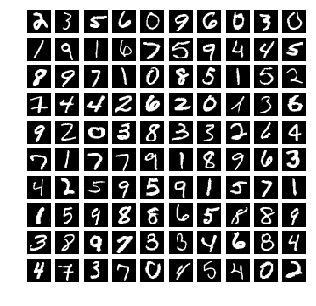

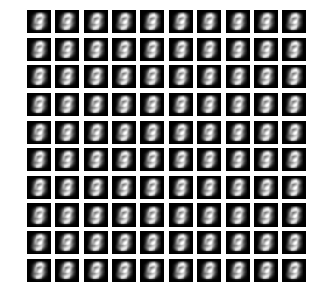

In [7]:
rows, cols = 10, 10
_, axes1 = plt.subplots(rows, cols, figsize=(5, 5))
_, axes2 = plt.subplots(rows, cols, figsize=(5, 5))

test_sample = data_stream.test_batch(rows*cols)
prediction = vae.predict(test_sample)

for i in range(rows):
    for j in range(cols):
        axes1[i][j].set_axis_off()
        axes1[i][j].imshow(np.reshape(test_sample[cols*i+j, :], [28, 28]), cmap='gray')

for i in range(rows):
    for j in range(cols):
        axes2[i][j].set_axis_off()
        axes2[i][j].imshow(np.reshape(prediction[cols*i+j,:], [28, 28]), cmap='gray')

plt.show()